In [2]:
# # Cell 1: Install required packages
# !pip install langgraph langchain langchain-groq langchain-community langchain-huggingface
# !pip install chromadb sentence-transformers pypdf tavily-python

In [1]:
import os
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, END
from langchain_groq import ChatGroq
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from tavily import TavilyClient
import tempfile
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Set your API keys
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")


In [5]:
# Initialize LangChain Groq
llm = ChatGroq(
    model_name="llama3-8b-8192",
    temperature=0.7
)
llm.invoke("Hello, world!")  # Test invocation

AIMessage(content="Hello, world! It's great to meet you! Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 14, 'total_tokens': 42, 'completion_time': 0.023333333, 'prompt_time': 0.002328515, 'queue_time': 0.24965084099999998, 'total_time': 0.025661848}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_dadc9d6142', 'finish_reason': 'stop', 'logprobs': None}, id='run--a8747632-b47a-43ea-9ca3-a5abd7318d56-0', usage_metadata={'input_tokens': 14, 'output_tokens': 28, 'total_tokens': 42})

In [6]:
tavily_client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [7]:
# Define State
class GraphState(TypedDict):
    question: str
    answer: str
    route: str
    validation_result: str
    attempt_count: int
    context: str

In [8]:
# Setup RAG Components
def setup_rag_system(pdf_path):
    """Setup RAG system with PDF, embeddings, and ChromaDB"""
    print("Setting up RAG system...")
    
    # Load PDF
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()
    print(f"Loaded {len(documents)} pages from PDF")
    
    # Split documents
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200
    )
    splits = text_splitter.split_documents(documents)
    print(f"Split into {len(splits)} chunks")
    
    # Create embeddings using HuggingFace
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2"
    )
    
    # Create ChromaDB vector store
    vectorstore = Chroma.from_documents(
        documents=splits,
        embedding=embeddings,
        persist_directory="./assignment_4/chroma_db"
    )
    
    print("RAG system setup complete!")
    return vectorstore

In [9]:
print("Creating vectorstore ...")
vectorstore = setup_rag_system("D:\AgenticAI\Assignments\llama2.pdf")



<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
C:\Users\varig\AppData\Local\Temp\ipykernel_21152\724340120.py:2: SyntaxWarning: invalid escape sequence '\A'
  vectorstore = setup_rag_system("D:\AgenticAI\Assignments\llama2.pdf")


Creating vectorstore ...
Setting up RAG system...
Loaded 77 pages from PDF
Split into 342 chunks


d:\AgenticAI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RAG system setup complete!


In [11]:
# Supervisor Node
def supervisor_node(state: GraphState):
    print(f"SUPERVISOR: Processing question: {state['question']}")
    print(f"SUPERVISOR: Attempt #{state.get('attempt_count', 0) + 1}")
    
    return {
        **state,
        "attempt_count": state.get("attempt_count", 0) + 1
    }

In [23]:
# Router Function
def router_function(state: GraphState):
    print("ROUTER: Analyzing question to determine route...")
    
    # Routing logic based on question content
    question = state['question'].lower()
    
    if any(word in question for word in ['current', 'today', 'latest', 'recent', 'news']):
        route = "web_crawler"
    elif any(word in question for word in ['llama', 'llama2', 'model', 'ai', 'document','knowledge']):
        route = "rag"
    else:
        route = "llm"
    
    print(f"ROUTER: Directing to {route}")
    
    return route

In [25]:
# LLM Node using LangChain Groq
def llm_node(state: GraphState):
    print("LLM NODE: Processing with LangChain Groq")
    
    try:
        response = llm.invoke(state["question"])
        answer = response.content
        
        print(f"LLM NODE: Generated answer: {answer[:100]}...")  # Print first 100 chars for brevity
        
        return {
            **state,
            "answer": answer,
            "context": "Direct LLM response",
            "route": "llm"
        }
    except Exception as e:
        print(f"LLM NODE: Error - {e}")
        return {
            **state,
            "answer": "Error in LLM processing",
            "context": "Error",
            "route": "llm"
        }

In [26]:
# RAG Node with ChromaDB and HuggingFace Embeddings
def rag_node(state: GraphState):
    print("RAG NODE: Processing with RAG using ChromaDB")
    
    try:
        # Retrieve relevant documents
        docs = vectorstore.similarity_search(state["question"], k=3)
        context = "\n\n".join([doc.page_content for doc in docs])
        
        print(f"RAG NODE: Retrieved {len(docs)} relevant documents")
        
        # Create prompt with context
        prompt = f"""Based on the following context, answer the question:

Context:
{context}

Question: {state['question']}

Answer:"""
        
        response = llm.invoke(prompt)
        answer = response.content
        
        print(f"RAG NODE: Generated answer: {answer[:100]}...")
        
        return {
            **state,
            "answer": answer,
            "context": f"RAG context with {len(docs)} documents",
            "route": "rag"
        }
    except Exception as e:
        print(f"RAG NODE: Error - {e}")
        return {
            **state,
            "answer": "Error in RAG processing",
            "context": "RAG Error",
            "route": "rag"
        }

In [27]:
# Web Crawler Node using Tavily
def web_crawler_node(state: GraphState):
    print("WEB CRAWLER NODE: Fetching real-time information using Tavily")
    
    try:
        # Search using Tavily
        search_response = tavily_client.search(
            query=state["question"],
            search_depth="basic",
            max_results=3
        )
        
        # Extract content from search results
        web_content = ""
        for result in search_response.get('results', []):
            web_content += f"Title: {result.get('title', '')}\n"
            web_content += f"Content: {result.get('content', '')}\n\n"
        
        if not web_content:
            web_content = "No relevant web content found."
        
        print(f"WEB CRAWLER NODE: Retrieved {len(search_response.get('results', []))} web results")
        
        # Generate answer using web content
        prompt = f"""Based on the following current web information, answer the question:

Web Information:
{web_content}

Question: {state['question']}

Answer with current information:"""
        
        response = llm.invoke(prompt)
        answer = response.content
        
        print(f"WEB CRAWLER NODE: Generated answer: {answer[:100]}...")
        
        return {
            **state,
            "answer": answer,
            "context": f"Web search with {len(search_response.get('results', []))} results",
            "route": "web_crawler"
        }
    except Exception as e:
        print(f"WEB CRAWLER NODE: Error - {e}")
        # Fallback to basic LLM response
        response = llm.invoke(f"Answer this question with current knowledge: {state['question']}")
        return {
            **state,
            "answer": response.content,
            "context": "Fallback LLM response (Tavily unavailable)",
            "route": "web_crawler"
        }

In [28]:
# Validation Node
def validation_node(state: GraphState):
    print("VALIDATION NODE: Checking answer quality")
    
    answer = state.get("answer", "")
    attempt_count = state.get("attempt_count", 0)
    
    # Simple validation rules
    is_valid = (
        len(answer) > 20 and  # Not too short
        "error" not in answer.lower() and  # No error messages
        answer.strip() != ""  # Not empty
    ) or attempt_count >= 3  # Max 3 attempts
    
    validation_result = "pass" if is_valid else "fail"
    print(f"VALIDATION NODE: {validation_result.upper()}")
    
    return {
        **state,
        "validation_result": validation_result
    }

In [29]:
# Validation Router
def validation_router(state: GraphState):
    if state["validation_result"] == "pass":
        return "final_output"
    else:
        return "supervisor"


In [30]:
# Final Output Node
def final_output_node(state: GraphState):
    print("FINAL OUTPUT NODE: Generating final response")
    
    final_answer = f"""
=== FINAL ANSWER ===
Question: {state['question']}
Answer: {state['answer']}
Route Used: {state['route']}
Context: {state.get('context', 'N/A')}
Attempts: {state['attempt_count']}
Validation: PASSED
==================
"""
    
    print(final_answer)
    return {**state, "final_output": final_answer}

In [31]:
# Build the Graph
def build_graph():
    workflow = StateGraph(GraphState)
    
    # Add nodes
    workflow.add_node("supervisor", supervisor_node)
    workflow.add_node("llm", llm_node)
    workflow.add_node("rag", rag_node) 
    workflow.add_node("web_crawler", web_crawler_node)
    workflow.add_node("validation", validation_node)
    workflow.add_node("final_output", final_output_node)
    
    # Add edges
    workflow.set_entry_point("supervisor")
    workflow.add_conditional_edges("supervisor", router_function, {
        "llm": "llm",
        "rag": "rag",
        "web_crawler": "web_crawler"
    })
    workflow.add_edge("llm", "validation")
    workflow.add_edge("rag", "validation")
    workflow.add_edge("web_crawler", "validation")
    workflow.add_conditional_edges("validation", validation_router, {
        "supervisor": "supervisor",
        "final_output": "final_output"
    })
    workflow.add_edge("final_output", END)
    
    return workflow.compile()

In [32]:
# Test the Graph
app = build_graph()

In [33]:


# Test with LLM route
print("=== TEST 1: LLM Route ===")
result1 = app.invoke({"question": "What is quantum computing?"})

print("\n" + "="*50 + "\n")



=== TEST 1: LLM Route ===
SUPERVISOR: Processing question: What is quantum computing?
SUPERVISOR: Attempt #1
ROUTER: Analyzing question to determine route...
ROUTER: Directing to llm
LLM NODE: Processing with LangChain Groq
LLM NODE: Generated answer: Quantum computing is a new paradigm in computing that uses the principles of quantum mechanics to pe...
VALIDATION NODE: Checking answer quality
VALIDATION NODE: FAIL
SUPERVISOR: Processing question: What is quantum computing?
SUPERVISOR: Attempt #2
ROUTER: Analyzing question to determine route...
ROUTER: Directing to llm
LLM NODE: Processing with LangChain Groq
LLM NODE: Generated answer: Quantum computing is a new paradigm in computing that uses the principles of quantum mechanics to pe...
VALIDATION NODE: Checking answer quality
VALIDATION NODE: FAIL
SUPERVISOR: Processing question: What is quantum computing?
SUPERVISOR: Attempt #3
ROUTER: Analyzing question to determine route...
ROUTER: Directing to llm
LLM NODE: Processing with LangC

In [36]:
# Test with RAG route  
print("=== TEST 2: RAG Route ===")
result2 = app.invoke({"question": "compare llama and llama2?"})

print("\n" + "="*50 + "\n")

=== TEST 2: RAG Route ===
SUPERVISOR: Processing question: compare llama and llama2?
SUPERVISOR: Attempt #1
ROUTER: Analyzing question to determine route...
ROUTER: Directing to rag
RAG NODE: Processing with RAG using ChromaDB
RAG NODE: Retrieved 3 relevant documents
RAG NODE: Generated answer: The text compares Llama 1 and Llama 2, specifically highlighting the differences in their performanc...
VALIDATION NODE: Checking answer quality
VALIDATION NODE: PASS
FINAL OUTPUT NODE: Generating final response

=== FINAL ANSWER ===
Question: compare llama and llama2?
Answer: The text compares Llama 1 and Llama 2, specifically highlighting the differences in their performance on various benchmarks and tasks.

From the text, we can see that:

* Llama 2 has a lower percentage of violations under the unqualified advice category, possibly due to the inclusion of a disclaimer ("I am not a professional") at times.
* Llama 2 shows great improvement over the pretrained Llama 2 in terms of truthfulness 

In [37]:
# Test with Web Crawler route
print("=== TEST 3: Web Crawler Route ===")
result3 = app.invoke({"question": "What are the latest developments in AI today?"})

=== TEST 3: Web Crawler Route ===
SUPERVISOR: Processing question: What are the latest developments in AI today?
SUPERVISOR: Attempt #1
ROUTER: Analyzing question to determine route...
ROUTER: Directing to web_crawler
WEB CRAWLER NODE: Fetching real-time information using Tavily
WEB CRAWLER NODE: Retrieved 3 web results
WEB CRAWLER NODE: Generated answer: Based on the web information, the latest developments in AI today include:

1. Meta's V-JEPA 2, an o...
VALIDATION NODE: Checking answer quality
VALIDATION NODE: PASS
FINAL OUTPUT NODE: Generating final response

=== FINAL ANSWER ===
Question: What are the latest developments in AI today?
Answer: Based on the web information, the latest developments in AI today include:

1. Meta's V-JEPA 2, an open-source AI world model, which has stepped into the spotlight and is considered a significant development in the AI research domain.

Note: This information is based on the most recent article published on MSN, which suggests that V-JEPA 2 is

In [42]:
# Save and View Graph Structure
def save_graph_png(app, filename="langgraph_structure.png"):
    """Save the graph structure as PNG"""
    try:
        # Get graph as PNG bytes
        png_bytes = app.get_graph().draw_mermaid_png()
        
        # Save to file
        with open(filename, "wb") as f:
            f.write(png_bytes)
        
        print(f"Graph saved as: {filename}")
        return png_bytes
    except Exception as e:
        print(f"Error saving graph: {e}")
        return None

# Save the graph
print("Saving graph structure...")
png_data = save_graph_png(app, "graph.png")


Saving graph structure...
Graph saved as: graph.png


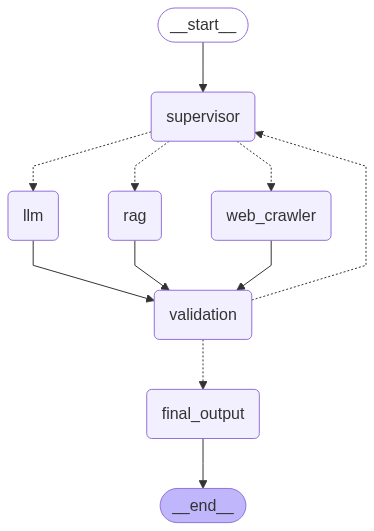

Graph displayed above and saved to file!


In [43]:
# Display Graph Visualization
try:
    from IPython.display import Image, display
    if png_data:
        display(Image(png_data))
        print("Graph displayed above and saved to file!")
    else:
        print("Could not generate graph visualization")
except ImportError:
    print("IPython not available for display, but graph saved to file")
except Exception as e:
    print(f"Display error: {e}")
    print("Graph structure (text):")
    print("supervisor -> [llm/rag/web_crawler] -> validation -> [supervisor (if fail) / final_output (if pass)]")
